In [1]:
import numpy as np
import uproot
import awkward as ak
import time
import ROOT
import mplhep as hep
import matplotlib as mpl
import matplotlib.pyplot as plt
hep.style.use(hep.style.ROOT)

Welcome to JupyROOT 6.24/06


## Option 1: Awkard + uproot + EDM4Hep file

total time: 0.43001389503479004 sec


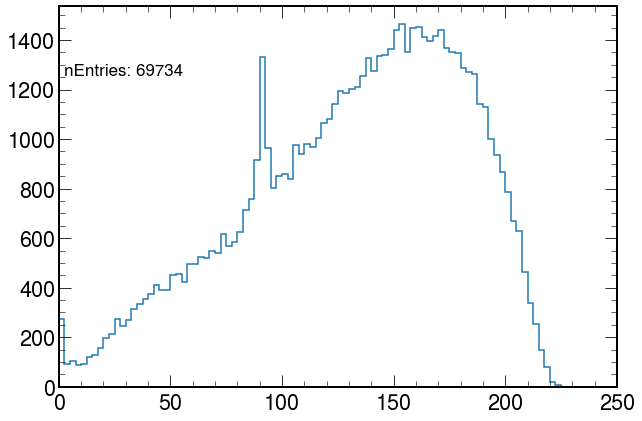

In [2]:
starttime = time.time()

up4_events = uproot.open("./edm4hep_output.root:events;6", num_workers=8)
#up4_events.show()
mu_index = up4_events['Muon#0/Muon#0.index'].array()

reco = up4_events['ReconstructedParticles'].arrays(
    ["ReconstructedParticles.energy", 
     "ReconstructedParticles.momentum.x",
     "ReconstructedParticles.momentum.y",
     "ReconstructedParticles.momentum.z",
     "ReconstructedParticles.charge"
    ]
)


## VERY important!! 
## go to RECO collection and get muons!!!
muons = reco[mu_index]

#Require 2 muons
cut = (ak.num(muons["ReconstructedParticles.charge"]) == 2)

#First and second muon
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]

invMass_up4 = np.sqrt(  (mu1['ReconstructedParticles.energy']     + mu2['ReconstructedParticles.energy'])**2 - 
                        (mu1['ReconstructedParticles.momentum.x'] + mu2['ReconstructedParticles.momentum.x'])**2  - 
                        (mu1['ReconstructedParticles.momentum.y'] + mu2['ReconstructedParticles.momentum.y'])**2  -
                        (mu1['ReconstructedParticles.momentum.z'] + mu2['ReconstructedParticles.momentum.z'])**2 
                     )


f, axs = plt.subplots(figsize=(10, 7))
h, bins = np.histogram(invMass_up4, range=[0,250], bins=100)
hep.histplot(h, bins)
axs.set_xlim([0, 250])
axs.text(0.01, 0.85, "nEntries: {:d}".format(sum(h)), horizontalalignment='left',verticalalignment='top', 
             transform=axs.transAxes, color = 'black', fontsize=17)



awkward_time = time.time() - starttime
print(f"total time: {awkward_time} sec")


## Option 2: EDM4hep with EventStore (python)

In [3]:
from EventStore import EventStore

roothist = ROOT.TH1D("roothist", "IsoMuons-Edm4hep", 100, 0, 250)

starttime = time.time()
events = EventStore('./edm4hep_output.root')

for event in events:
        
    muons = event.get('Muon') # Make sure to get the name right
    if len(muons) != 2: continue

    
    ##get momentum and energy of muons
    mom1 = muons[0].getMomentum()
    em1 = muons[0].getEnergy()
    mom2 = muons[1].getMomentum()
    em2 = muons[1].getEnergy()
    # calculate the mass, fill histogram, etc.
    
    px = mom1.x + mom2.x
    py = mom1.y + mom2.y
    pz = mom1.z + mom2.z
    e  = em1 + em2  
    
    roothist.Fill(
            np.sqrt(e**2 - px**2 - py**2 - pz**2)
        )

edm4hep_EventStore_time = time.time() - starttime
print(f"total time: {edm4hep_EventStore_time} sec")
    

total time: 5.3989715576171875 sec


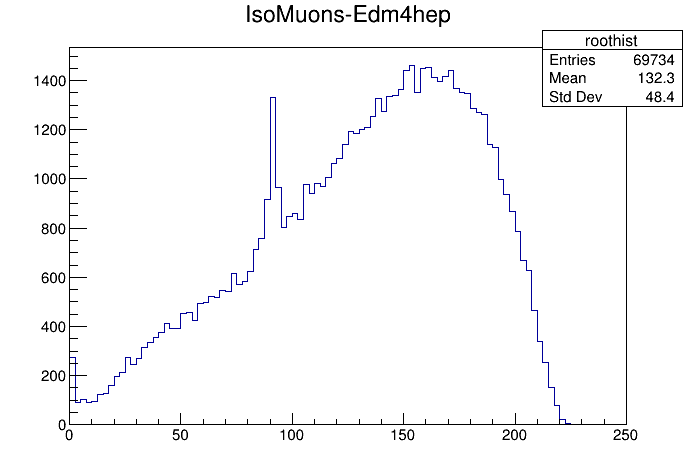

In [4]:
canvas = ROOT.TCanvas()
roothist.Draw()
canvas.Draw()

## Opton 3: EDM4hep with EventStore (C++)

In [5]:
import ROOT

cpp_code = """

#include "podio/ROOTReader.h"
#include "podio/EventStore.h"

#include "edm4hep/ReconstructedParticleCollection.h"




void compute(TH1D& roothist, const char* FILEN) {
    
    
    
    auto reader = podio::ROOTReader();
    reader.openFile(FILEN);


    auto store = podio::EventStore();
    store.setReader(&reader);
    
    
    
    for (size_t i = 0; i < reader.getEntries(); ++i) {
       auto& muons = store.get<edm4hep::ReconstructedParticleCollection>("Muon");
      
       if (muons.size() != 2) {
           store.clear();
           reader.endOfEvent();
           continue;
       }
       
       // the two muons
       const auto mom1 = muons[0].getMomentum(); 
       const auto mom2 = muons[1].getMomentum();
       
       
       const auto em1 = muons[0].getEnergy();
       const auto em2 = muons[1].getEnergy();
       
       float px =  mom1.x + mom2.x;
       float py =  mom1.y + mom2.y;
       float pz =  mom1.z + mom2.z;
       float e  =  em1 + em2;
       
       roothist.Fill(  
           sqrt(e*e - px*px - py*py - pz*pz  )
       );

      // at the end of each event
      store.clear();
      reader.endOfEvent();
    }


}
"""

ROOT.gInterpreter.AddIncludePath("/home/ilc/podio");
ROOT.gSystem.Load("libpodioRootIO.so")


ROOT.gSystem.Load("/home/ilc/EDM4hep/install/lib/libedm4hep.so");
ROOT.gSystem.Load("/home/ilc/EDM4hep/install/lib/libedm4hepDict.so");



ROOT.gInterpreter.Declare(cpp_code)




True

In [6]:
import time
starttime = time.time()

roothist2 = ROOT.TH1D("roothist2", "invMass of Iso_muons", 100, 0, 250)

ROOT.compute(roothist2, "./edm4hep_output.root")


cppedm_time = time.time() - starttime
print(f"total time: {cppedm_time} sec")


total time: 2.6133415699005127 sec


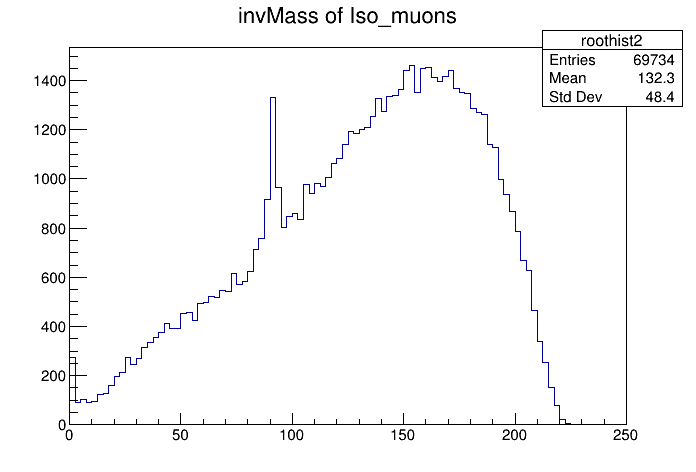

In [7]:
canvas = ROOT.TCanvas()
roothist2.Draw()
canvas.Draw()

from 8th February 2022

| EDM4Hep + uproot + awkward          | EDM4Hep + eventStore (python)|  EDM4Hep + eventStore (C++) 
| ---                                 | ---                          |  ---                        
| 0.43                                | 5.40                         |  2.61                     
